In [1]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import numpy as np
from matplotlib import pyplot as plt
from IPython.core.debugger import set_trace
import random
from IPython.display import Image
import torchaudio
import librosa
import matplotlib.pyplot as plt
import librosa.display
import glob
import os.path
import IPython
import random
 

/home/kchow/.conda/envs/SpeechVAE/lib/python2.7/site-packages/sklearn/utils/fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


In [2]:
# try a dataset, save all spectrograms somewhere
filenames = glob.glob("/home/kchow/datasets/clips/*.mp3")
spectrogram_clips = []
mel_spectrogram_clips = []

restart = False

number_of_clips = 10

# if numpy loaded 
if not restart and os.path.isfile('spec_clips_sample.npy') and os.path.isfile('mel_spec_clips_sample.npy'):
    spectrogram_clips = np.load('spec_clips_sample.npy')
    mel_spectrogram_clips = np.load('mel_spec_clips_sample.npy')
else:
    for f in filenames:
        print(f)
        y, sr = librosa.load(f)
        D = np.abs(librosa.stft(y))**2
        D = D[:1024,:1939]
        S = librosa.feature.melspectrogram(S=D)
        S = S[:128,:1939]
        if np.shape(D)[0] != 1024 or np.shape(D)[1] != 1939 or np.shape(S)[0] != 128 or np.shape(S)[1] != 1939:
            continue
        spectrogram_clips.append(D)
        mel_spectrogram_clips.append(S)
        if len(spectrogram_clips) == number_of_clips:
            break

np.save('spec_clips_sample.npy', np.array(spectrogram_clips))
np.save('mel_spec_clips_sample.npy', np.array(mel_spectrogram_clips))


In [3]:
snip_mel_spectrogram_clips = mel_spectrogram_clips[:10,:,:100]


In [4]:
batch_size = 8
epochs = 100
no_cuda = False
seed = 1
beta = 1
log_interval = 1000
cuda = not no_cuda and torch.cuda.is_available()
kwargs = {'num_workers': 0, 'pin_memory': True} if cuda else {}
loss_function_type = 'Beta' # [DIP-VAE1, 'DIP-VAE2, Beta']
latent_dimensions = 128
fc_dimensions = 512

In [5]:
torch.manual_seed
device = torch.device("cuda" if cuda else "cpu")

In [102]:
time_steps = 100
freq_filters = 128
channels = 30
k_size = 3
a = 122
b = 94 #1933
# with max pooling new dimensions 
c = 18
d = 13
class MusicMelAEConv2D(nn.Module):
    def __init__(self):
        super(MusicMelAEConv2D, self).__init__()
        self.conv1 = nn.Conv2d(1, channels, kernel_size=k_size)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=k_size)
        self.conv3 = nn.Conv2d(channels, channels, kernel_size=k_size)
        
        self.maxpool1 = nn.MaxPool2d((3, 3), return_indices=True)
        self.maxpool2 = nn.MaxPool2d((2, 2), return_indices=True)
        
        # max pool
        # batch norm 
        # 23 
        
        self.fc1 = nn.Linear(c*d*channels, fc_dimensions)
        self.fc2 = nn.Linear(latent_dimensions, fc_dimensions)
        self.fc3 = nn.Linear(fc_dimensions, c*d*channels)
 
        self.deconv1 = nn.ConvTranspose2d(channels, channels, kernel_size=k_size) #to get same size, just kernel+1
        self.deconv2 = nn.ConvTranspose2d(channels, channels, kernel_size=k_size)
        self.deconv3 = nn.ConvTranspose2d(channels, 1, kernel_size=k_size)
        
        self.maxunpool1 = nn.MaxUnpool2d((2, 2))
        self.maxunpool2 = nn.MaxUnpool2d((3, 3))
        
        self.indicespool1 = None
        self.indicespool2 = None
        
        self.outputsizepool1 = None
        self.outputsizepool2 = None
    
    def encode(self, x):
        x = F.elu(self.conv1(x))
        self.outputsizepool1 = x.size()
        x, self.indicespool1 = self.maxpool1(x)
        
        x = F.elu(self.conv2(x))
        self.outputsizepool2 = x.size()
        x, self.indicespool2 = self.maxpool2(x)
        
        x = F.elu(self.conv3(x))
        #set_trace()
        x = x.view(x.size(0), -1)
        x = F.sigmoid(self.fc1(x))
        
        return x
    
    def decode(self, z):
        #set_trace()
        z = F.elu(self.fc3(z))
        z = z.view(z.size(0), channels, c, d)
        z = F.elu(self.deconv1(z))
        z = self.maxunpool1(z, self.indicespool2, output_size = self.outputsizepool2)
        z = F.elu(self.deconv2(z))
        # size aint right
        z = self.maxunpool2(z, self.indicespool1, output_size = self.outputsizepool1)
        z = F.sigmoid(self.deconv3(z))
        return z
    
    def forward(self, x):
        x = self.encode(x)
        return self.decode(x)


In [112]:
model = MusicMelAEConv2D().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
#optimizer = optim.SGD(model.parameters(), lr=1e-3)
average_losses = []

def loss_function(recon_x, x):
    MSE = F.mse_loss(recon_x, x)
    return MSE 

# code from https://stackoverflow.com/questions/8290397/how-to-split-an-iterable-in-constant-size-chunks
def data_batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

def train(epoch):
    model.train()
    train_loss = 0
    subset_data = snip_mel_spectrogram_clips[:10]
    random.shuffle(subset_data)
    # shuffle subset
    for data in data_batch(subset_data, batch_size):
        # update this to use a larger batch size 
        data = np.array(data)
        # data columns not consistent
        #data = data[:freq_filters,:time_steps]
        #if np.shape(data)[0] != freq_filters or np.shape(data)[1] != time_steps:
            #continue
        data = torch.from_numpy(data)
        #set_trace()
        # how data is set up here MATTERS. Double check with patrick 
        #set_trace()
        
        #data = torch.transpose(data, 1, 2)
        #data = data.contiguous().view(data.size(0), -1, freq_filters*time_steps)
        data = data.view(data.size(0), 1, freq_filters, time_steps)
        #set_trace()
        data = data.to(device, dtype=torch.float)
        optimizer.zero_grad()
        recon_batch = model(data)
        loss = loss_function(recon_batch, data) #/data.size(0)
        loss.backward()
        #use clip here 
        #clip_gradient = 2
        #nn.utils.clip_grad_norm_(model.parameters(), clip_gradient)
        #set_trace()
        train_loss += loss.item()
        optimizer.step()
        print(epoch, loss.item())
    average_loss = train_loss #/ len(subset_data)
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, average_loss))#len(mel_spectrogram_clips)))
    average_losses.append(average_loss)

def save_checkpoint(state, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    

1 7160.81738281
1 2630.12402344
====> Epoch: 1 Average loss: 9790.9414
2 6542.39111328
2 2662.68603516
====> Epoch: 2 Average loss: 9205.0771
3 10421.9570312
3 156.552047729
====> Epoch: 3 Average loss: 10578.5091
4 5289.13867188
4 20686.8261719
====> Epoch: 4 Average loss: 25975.9648
5 156.384567261
5 20686.3242188
====> Epoch: 5 Average loss: 20842.7088
6 156.220596313
6 156.123382568
====> Epoch: 6 Average loss: 312.3440
7 156.014663696
7 155.901275635
====> Epoch: 7 Average loss: 311.9159
8 155.79598999
8 155.692184448
====> Epoch: 8 Average loss: 311.4882
9 155.597839355
9 155.516983032
====> Epoch: 9 Average loss: 311.1148
10 155.449508667
10 155.395172119
====> Epoch: 10 Average loss: 310.8447
11 155.353027344
11 155.319244385
====> Epoch: 11 Average loss: 310.6723
12 155.292877197
12 155.271469116
====> Epoch: 12 Average loss: 310.5643
13 155.253158569
13 155.238433838
====> Epoch: 13 Average loss: 310.4916
14 155.226257324
14 155.21661377
====> Epoch: 14 Average loss: 310.4429

114 155.058517456
114 155.058364868
====> Epoch: 114 Average loss: 310.1169
115 155.058242798
115 155.058120728
====> Epoch: 115 Average loss: 310.1164
116 155.057983398
116 155.057846069
====> Epoch: 116 Average loss: 310.1158
117 155.057693481
117 155.057571411
====> Epoch: 117 Average loss: 310.1153
118 155.057449341
118 155.057312012
====> Epoch: 118 Average loss: 310.1148
119 155.057189941
119 155.057067871
====> Epoch: 119 Average loss: 310.1143
120 155.056930542
120 155.056808472
====> Epoch: 120 Average loss: 310.1137
121 155.056686401
121 155.056549072
====> Epoch: 121 Average loss: 310.1132
122 155.056411743
122 155.056274414
====> Epoch: 122 Average loss: 310.1127
123 155.056137085
123 155.056030273
====> Epoch: 123 Average loss: 310.1122
124 155.055892944
124 155.055755615
====> Epoch: 124 Average loss: 310.1116
125 155.055618286
125 155.055511475
====> Epoch: 125 Average loss: 310.1111
126 155.055374146
126 155.055236816
====> Epoch: 126 Average loss: 310.1106
127 155.0551

226 155.042053223
====> Epoch: 226 Average loss: 310.0842
227 155.042037964
227 155.042007446
====> Epoch: 227 Average loss: 310.0840
228 155.041992188
228 155.041976929
====> Epoch: 228 Average loss: 310.0840
229 155.041946411
229 155.041915894
====> Epoch: 229 Average loss: 310.0839
230 155.041900635
230 155.041854858
====> Epoch: 230 Average loss: 310.0838
231 155.0418396
231 155.041809082
====> Epoch: 231 Average loss: 310.0836
232 155.041809082
232 155.041778564
====> Epoch: 232 Average loss: 310.0836
233 155.041763306
233 155.041717529
====> Epoch: 233 Average loss: 310.0835
234 155.041702271
234 155.041671753
====> Epoch: 234 Average loss: 310.0834
235 155.041656494
235 155.041641235
====> Epoch: 235 Average loss: 310.0833
236 155.041610718
236 155.041595459
====> Epoch: 236 Average loss: 310.0832
237 155.041564941
237 155.041534424
====> Epoch: 237 Average loss: 310.0831
238 155.041519165
238 155.041488647
====> Epoch: 238 Average loss: 310.0830
239 155.04145813
239 155.0414276

338 155.037796021
338 155.037796021
====> Epoch: 338 Average loss: 310.0756
339 155.037780762
339 155.037765503
====> Epoch: 339 Average loss: 310.0755
340 155.037750244
340 155.037734985
====> Epoch: 340 Average loss: 310.0755
341 155.037750244
341 155.037719727
====> Epoch: 341 Average loss: 310.0755
342 155.037734985
342 155.037719727
====> Epoch: 342 Average loss: 310.0755
343 155.037689209
343 155.037689209
====> Epoch: 343 Average loss: 310.0754
344 155.03767395
344 155.037658691
====> Epoch: 344 Average loss: 310.0753
345 155.037658691
345 155.037643433
====> Epoch: 345 Average loss: 310.0753
346 155.037643433
346 155.037628174
====> Epoch: 346 Average loss: 310.0753
347 155.037612915
347 155.037612915
====> Epoch: 347 Average loss: 310.0752
348 155.037612915
348 155.037582397
====> Epoch: 348 Average loss: 310.0752
349 155.037582397
349 155.03755188
====> Epoch: 349 Average loss: 310.0751
350 155.03755188
350 155.037536621
====> Epoch: 350 Average loss: 310.0751
351 155.0375366

446 155.035720825
====> Epoch: 446 Average loss: 310.0715
447 155.035736084
447 155.035705566
====> Epoch: 447 Average loss: 310.0714
448 155.035705566
448 155.035705566
====> Epoch: 448 Average loss: 310.0714
449 155.035690308
449 155.035690308
====> Epoch: 449 Average loss: 310.0714
450 155.035675049
450 155.035675049
====> Epoch: 450 Average loss: 310.0714
451 155.035675049
451 155.035644531
====> Epoch: 451 Average loss: 310.0713
452 155.035644531
452 155.035644531
====> Epoch: 452 Average loss: 310.0713
453 155.035629272
453 155.035629272
====> Epoch: 453 Average loss: 310.0713
454 155.035614014
454 155.035614014
====> Epoch: 454 Average loss: 310.0712
455 155.035598755
455 155.035598755
====> Epoch: 455 Average loss: 310.0712
456 155.035583496
456 155.035583496
====> Epoch: 456 Average loss: 310.0712
457 155.035583496
457 155.035583496
====> Epoch: 457 Average loss: 310.0712
458 155.035583496
458 155.035552979
====> Epoch: 458 Average loss: 310.0711
459 155.035552979
459 155.0355

555 155.034255981
====> Epoch: 555 Average loss: 310.0685
556 155.034255981
556 155.034240723
====> Epoch: 556 Average loss: 310.0685
557 155.034240723
557 155.034240723
====> Epoch: 557 Average loss: 310.0685
558 155.034240723
558 155.034225464
====> Epoch: 558 Average loss: 310.0685
559 155.034225464
559 155.034225464
====> Epoch: 559 Average loss: 310.0685
560 155.034225464
560 155.034225464
====> Epoch: 560 Average loss: 310.0685
561 155.034194946
561 155.034194946
====> Epoch: 561 Average loss: 310.0684
562 155.034194946
562 155.034194946
====> Epoch: 562 Average loss: 310.0684
563 155.034194946
563 155.034194946
====> Epoch: 563 Average loss: 310.0684
564 155.034194946
564 155.034179688
====> Epoch: 564 Average loss: 310.0684
565 155.034179688
565 155.034164429
====> Epoch: 565 Average loss: 310.0683
566 155.034164429
566 155.034164429
====> Epoch: 566 Average loss: 310.0683
567 155.034164429
567 155.03414917
====> Epoch: 567 Average loss: 310.0683
568 155.034133911
568 155.03413

665 155.033203125
665 155.033218384
====> Epoch: 665 Average loss: 310.0664
666 155.033203125
666 155.033203125
====> Epoch: 666 Average loss: 310.0664
667 155.033187866
667 155.033187866
====> Epoch: 667 Average loss: 310.0664
668 155.033187866
668 155.033157349
====> Epoch: 668 Average loss: 310.0663
669 155.033157349
669 155.033157349
====> Epoch: 669 Average loss: 310.0663
670 155.033157349
670 155.033157349
====> Epoch: 670 Average loss: 310.0663
671 155.03314209
671 155.03314209
====> Epoch: 671 Average loss: 310.0663
672 155.033126831
672 155.033126831
====> Epoch: 672 Average loss: 310.0663
673 155.033126831
673 155.033126831
====> Epoch: 673 Average loss: 310.0663
674 155.033126831
674 155.033126831
====> Epoch: 674 Average loss: 310.0663
675 155.033111572
675 155.033111572
====> Epoch: 675 Average loss: 310.0662
676 155.033111572
676 155.033111572
====> Epoch: 676 Average loss: 310.0662
677 155.033111572
677 155.033111572
====> Epoch: 677 Average loss: 310.0662
678 155.033111

774 155.032424927
====> Epoch: 774 Average loss: 310.0648
775 155.032424927
775 155.032424927
====> Epoch: 775 Average loss: 310.0648
776 155.032394409
776 155.032409668
====> Epoch: 776 Average loss: 310.0648
777 155.032394409
777 155.032409668
====> Epoch: 777 Average loss: 310.0648
778 155.032394409
778 155.032409668
====> Epoch: 778 Average loss: 310.0648
779 155.032394409
779 155.032409668
====> Epoch: 779 Average loss: 310.0648
780 155.032394409
780 155.032409668
====> Epoch: 780 Average loss: 310.0648
781 155.032394409
781 155.03237915
====> Epoch: 781 Average loss: 310.0648
782 155.03237915
782 155.03237915
====> Epoch: 782 Average loss: 310.0648
783 155.03237915
783 155.03237915
====> Epoch: 783 Average loss: 310.0648
784 155.03237915
784 155.03237915
====> Epoch: 784 Average loss: 310.0648
785 155.03237915
785 155.032394409
====> Epoch: 785 Average loss: 310.0648
786 155.03237915
786 155.032409668
====> Epoch: 786 Average loss: 310.0648
787 155.03237915
787 155.03237915
====>

885 155.031906128
====> Epoch: 885 Average loss: 310.0638
886 155.031921387
886 155.031906128
====> Epoch: 886 Average loss: 310.0638
887 155.031890869
887 155.031890869
====> Epoch: 887 Average loss: 310.0638
888 155.031890869
888 155.031890869
====> Epoch: 888 Average loss: 310.0638
889 155.031890869
889 155.031890869
====> Epoch: 889 Average loss: 310.0638
890 155.031890869
890 155.031890869
====> Epoch: 890 Average loss: 310.0638
891 155.031890869
891 155.031890869
====> Epoch: 891 Average loss: 310.0638
892 155.031890869
892 155.031890869
====> Epoch: 892 Average loss: 310.0638
893 155.031890869
893 155.031890869
====> Epoch: 893 Average loss: 310.0638
894 155.031890869
894 155.031890869
====> Epoch: 894 Average loss: 310.0638
895 155.031890869
895 155.031890869
====> Epoch: 895 Average loss: 310.0638
896 155.031860352
896 155.031860352
====> Epoch: 896 Average loss: 310.0637
897 155.031860352
897 155.031860352
====> Epoch: 897 Average loss: 310.0637
898 155.031860352
898 155.0318

994 155.031509399
====> Epoch: 994 Average loss: 310.0630
995 155.031509399
995 155.031494141
====> Epoch: 995 Average loss: 310.0630
996 155.031494141
996 155.031478882
====> Epoch: 996 Average loss: 310.0630
997 155.031463623
997 155.031463623
====> Epoch: 997 Average loss: 310.0629
998 155.031448364
998 155.031448364
====> Epoch: 998 Average loss: 310.0629
999 155.031448364
999 155.031448364
====> Epoch: 999 Average loss: 310.0629


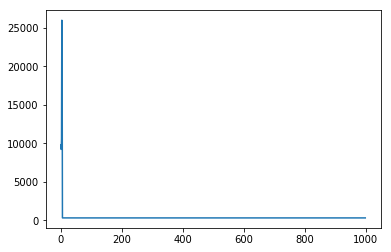

In [113]:
for epoch in range(1, 1000):
    train(epoch)
plt.figure(1)
plt.plot(average_losses)
plt.show()

In [1]:
# AE
# reconstruct signal and see how it looks. 
with torch.no_grad():
    sample = snip_mel_spectrogram_clips[0]
    sample = torch.from_numpy(sample)
    #sample = torch.transpose(sample, 0, 1)
    sample = sample.contiguous().view(1, 1, freq_filters, time_steps)
    sample = sample.to(device, dtype=torch.float)
    z = model.encode(sample)
    sample = model.decode(z).cpu()
    sample = sample.view(1, freq_filters, time_steps)
 
    librosa.display.specshow(librosa.power_to_db(sample[0], ref=np.max), y_axis='mel', fmax=8000, x_axis='time')
#y_out = librosa.istft(sample[0].numpy, length=99304)
#IPython.display.Audio(data=y_out, rate=22050)


NameError: name 'torch' is not defined

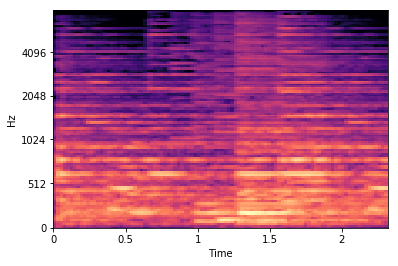

In [106]:
librosa.display.specshow(librosa.power_to_db(snip_mel_spectrogram_clips[0], ref=np.max), y_axis='mel', fmax=8000, x_axis='time')
